# Learning Best Practices for Model Evaluation and Hyperparameter Tuning

In the previous chapter, you learned about the essential machine learning algorithms for classification and how to get our data into shape before we feed it into those algorithms. Now, it's time to learn about the best practices of building good machine learning models by fine-tuning the algorithms and evaluating the model's performance. In this chapter, we will learn how to do the following:
* Obtain unbiased estimates of a model's performance. 
* Diagnose the common problems of machine learning algorithms. 
* Fine-tune machine learning models. 
* Evaluate predictive models using different performance metrics. 

# Streamlining workflows with pipelines

When we applied different preprocessing techniques in the previous chapters, such as standardization for feature scale or principal component analysis for data compression, you learned that we have to reuse the parameters that we obtained during the fitting of the training data to scale and compress any new data, such as the samples in the separate test dataset. In this section, you will learn about an extremely handy tool, the *Pipeline* class in scikit-learn. It allows us to fit a model including an arbitrary number of transformation steps and apply it to make predictions about new data. 

# Loading the Breast Cancer Wisconsin dataset

In this chapter, we will be working with the Breast Cancer Wisconsin dataset, which contains 569 samples of malignant and benign tumor cells. The first two columns in the dataset store the unique ID numbers of the samples and the corresponding diagnoses (*M* = malignant, *B* = belign), respectively. Columns 3-32 contain 30 real-valued features that have been computed from digitized images of the cell nuclei, which can be used to build a model to predict whether a tumor is benign or malignant. The Breast Cancer Wisconsin dataset has been deposited in the UCI Machine Learning Repository. 

In this section, we willl read the dataset and split it to training and test datasets in three simple steps: 

* We will start by reading in the dataset using *pandas*: 

In [1]:
import pandas as pd

# df = pd.read_csv('https://archive.ics.uci.edu/ml/'
#                  'machine-learning-databases/'
#                  'breast-cancer-wisconsin/'
#                  'wdbc.data')
df = pd.read_csv('wdbc.data', header=None)

* Next, we assign the 30 features to a NumPy array *x*. Using a *LabelEncoder* object, we transform the class labels from their original string representation ('M' and 'B') into integer: 

In [2]:
from sklearn.preprocessing import LabelEncoder

X = df.iloc[:, 2:].values
y = df.iloc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

After encoding the class labels (diagnosis) in an array *y*, the malignant tumors are now represented as class 1, and the benign tumors are represented as class 0, respectively. We can double-check this mapping by calling the *transform* method of the fitted *LabelEncoder* on two dummy class labels: 

In [3]:
le.transform(['M', 'B'])

array([1, 0])

* Before we construct our first model pipeline in the following subsection, let us divide the dataset into a separate training dataset (80 percent of the data) and a separate test dataset (20 percent of the data): 

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.20, stratify=y, 
                     random_state=1)

# Combining transformers and estimators in a pipeline

In the previous chapter, you learned that many learning algorithms require input features on the same scale for optimal performance. Thus, we need to standardize the columns in the Breast Cancer Wisconsin dataset before we can feed them to a linear classifier, such as logistic regression. Furthermore, let's assume that we want to compress our data from the initial 30 dimensions onto a lower two-dimensional subspace via **Principal Component Analysis (PCA)**, a feature extraction technique for dimensionality reduction. 

Instead of going though the fitting and transformation steps for the training and test datasets separately, we can chain the *StandardScaler*, *PCA* and *LogisticRegression* objects in a pipeline: 

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(), 
                        PCA(n_components=2), 
                        LogisticRegression(random_state=1))
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.956


The *make_pipeline* function takes an arbitrary number of scikit-learn transformers (objects that support the *fit* and *transform* methods as input), followed by a scikit-learn estimator that implements the *fit* and *predict* methods. In our preceding code example, we provided two transformers, *StandardScaler* and *PCA*, and a *LogisticRegression* estimator as inputs to the *make_pipeline* function, which constructs a scikit-learn *Pipeline* object from these objects. 

We can think of a scikit-learn *Pipeline* as a meta-estimator or wrapper around those individual transformers and estimators. If we call the *fit* method of *Pipeline*, the data will be passed down a series of transformers via *fit* and *transform* calls on these intermediate steps until it arrives at the estimator object (the final element in a pipeline). The estimator will then be fitted to the transformed training data. 

We we executed the *fit* method on the *pipe_lr* pipeline in the preceding code example, *StandardScaler* first performed *fit* and *transform* calls on the training data. Second, the transformed training data was passed on to the next object in the pipeline, *PCA*. Similar to the previous step, *PCA* also executed *fit* and *transform* on the scaled input data and passed it to the final element of the pipeline, the estimator. 

Finally, the *LogisticRegression* estimator was fit to the training data after it underwent transformations via *StandardScaler* and *PCA*. Again, we should note that there is no limit to the number of intermediate steps in a pipeline; however, the last pipeline element has to be an esimator. 

Similar to calling *fit* on the pipeline, pipelines also implement a *predict* method. If we feed a dataset to the *predict* call of a *Pipeline* object instance, the data will be pass through the intermediate steps via *transform* calls. In the final step, the estimator object will then return a prediction on the transformed data. 

The pipelines of scikit-learn library are immensely useful wrapper tools, which we will use frequently throughout the rest of this book. To make sure that you have got a good grasp of how *Pipeline* objects works, please take a close look at the following illustration, which summarize our discussion from the previous paragraphs: 

<img src='images/06_01.png'>

# Using k-fold cross-validation to assess model performance 

One of the key steps in building a machine learning model is to estimate its performance on data that the model has not seen before. Let's assume that we fit our model on training dataset and use the same data to estimate how well it performs on new data. We remember that a model can either suffer from underfitting (high bias) if the model is too simple, or it can overfit the training data (high variance) if the model is too complex for the underlying training data. 

To find an acceptable bias-variance trade-off, we need to evaluate our model carefully. In this section, you will learn about the common cross-validation techniques **holdout cross-validation** and **k-fold cross-validation**, which can help us obtain reliable estimates of the model's generalization performance, that is, how well the model performs on unseen data. 

## The holdout method 

A classic and popular approach for estimating the generalization performance of machine learning models is holdout cross-validation. Using the holdout method, we split our initial dataset into a separate training and test dataset, the former is used for model training, and the latter is used to estimate its generalization performance. However, in typical machine learning applications, we are also interested in tuning and comparing different parameter settings to further improve the performance for making predictions on unseen data. This process is called **model selection**, where the term model selection refers to a given classification problem for which we want to select the *optimal* values of tuning parameters (also called hyperparameters). However, if we reuse the same test dataset over and over again during the model selection, it will become part of our training data and thus the model will be more likely to overfit. Despite this issue, many people still use the test set for model selection, which is not a good machine learning practice. 

A better way of using the holdout method for model selection is to separate the data into three parts: a training set, a validation set, and a test set. The training set is used to fit the different models, and the performance on the validation set is then used for the model selection. The advantage of having a test set that the model has not seen before during the training and model selection steps is that we can obtain a less biased estimate of its ability to generalize to new data. The following figure illustrates the concept of holdout cross-validation, where we use a validation set to repeatedly evaluate the performance of the model after training using different parameter values. Once we are satisfied with the tuning of hyperparameter values, we estimate the model's generalization performance on the test dataset: 

<img src='images/06_02.png'>

A disadvantage of the holdout method is that the performance estimate may be very sensitive to how we partition the training set into the training and validation subsets; the estimate will vary for different samples of the data. In the next subsection, we will take a look at a more robust technique for performance estimation, **k-fold cross validation**, where we repeat the holdout method *k* times on *k*-subsets of the training data. 

## K-fold cross-validation

In k-fold cross-validation, we randomly split the training dataset into *k* folds without replacement, where $k-1$ folds are used for the model training, and one fold is used for performance evaluation. This procedure is repeated *k* times so that we obtain *k* models and performance estimates. 

We then calculate the average performance of the models based on the different, independent folds to obtain a performance estimate that is less sensitive to the sub-partitioning of the training data compared to the holdout method. Typically, we use k-fold cross-validation for model tuning, that is, findind the optimal hyperparameter values that yields a satisfying generalization performance. 

Once we have found satisfactory hyperparameter values, we can retrain the model on the complete training set and obtain a final performance estimate using the independent test set. The rationale behind fitting a model to the whole training dataset after k-fold cross-validation is that providing more training samples to a learning algorithm usually results in a more accurate and robust model. 

Since k-fold cross-validation is a resampling technique without replacement, the advantage of this approach is that each sample point will be used for training and validation (as part of a test fold) exactly once, which yields a lower-variance estimate of the model performance than the holdout method. The following figure summarizes the concept behind k-fold cross validation with $k=10$. The training dataset is divided into 10 folds, and during the 10 iterations, nine folds are used for training, and one fold will be used as the test set for the model evaluation. Also, the estimated performances $E_i$ (for example, classification accuracy or error) for each fold are then used to calculate the estimated average performance $E$ of the model: 

<img src='images/06_03.png'>

A good standard value for $k$ in k-fold cross-validation is 10, as empirical evidence showns. For instance, experiments by Ron Kohavi on various real-world datasets suggests that 10-fold cross-validation offers the best trade-off between bias and variance. 

However, if we are working with relatively small training sets, it can be useful to increase the number of folds. If we increase the value of $k$, more training data will be used in each iteration, which results in a lower bias towards estimating the generalization performance by averaging the individual model estimates. However, large values of $k$ will also increase the runtime of the cross-validation algorithm and yield estimates with higher variance, since the training folds will be more similar to each other. On the other hand, if we are working with large datasets, we can choose a small value of $k$, for example, $k=5$, and still obtain an accurate estimate of the average performance of the model while reducing the computational cost of refitting and evaluating the model on different folds. 

A special case of k-fold cross-validation is the **Leave-one-out cross-validation (LOOCV)** method. In LOOCV, we set the number of folds equal to the number of training samples ($k = n$) so that only training sample is used for testing during each iteration, which is a recommended approach for working with very small datasets. 

A slight improvement over the standard k-fold cross-validation approach is stratified k-fold cross-validation, which can yield better bias and variance estimates, especially in cases of unequal class proportions. In stratified cross-validation, the class proportions are preserved in each fold to ensure that each fold is representative of the class proportions in the training dataset, which we will illustrate by using the *StratifiedKFold* iterator in scikit-learn: 

In [6]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10, 
                        random_state=1).split(X_train, 
                                              y_train)
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %2d, Class dist.: %s, Acc: %.3f' 
          % (k+1, np.bincount(y_train[train]), score))
print('\nCV accuracy: %.3f +/- %.3f' 
      % (np.mean(scores), np.std(scores)))

Fold:  1, Class dist.: [256 153], Acc: 0.935
Fold:  2, Class dist.: [256 153], Acc: 0.935
Fold:  3, Class dist.: [256 153], Acc: 0.957
Fold:  4, Class dist.: [256 153], Acc: 0.957
Fold:  5, Class dist.: [256 153], Acc: 0.935
Fold:  6, Class dist.: [257 153], Acc: 0.956
Fold:  7, Class dist.: [257 153], Acc: 0.978
Fold:  8, Class dist.: [257 153], Acc: 0.933
Fold:  9, Class dist.: [257 153], Acc: 0.956
Fold: 10, Class dist.: [257 153], Acc: 0.956

CV accuracy: 0.950 +/- 0.014


First, we initialized the *StratifiedKFold* iterator from *sklearn.model_selection* module with the *y_train* class labels in the training set, and we specified the number of folds via the *n_splits* parameter. When we used the *kfold* iterator to loop through the *k* folds, we used the returned indices in *train* to fit the logistic regression pipeline that we set up at the beginning of this chapter. Using the *pipe_lr* pipeline, we ensured that the samples were scaled properly (for instance, standardized) in each iteration. We then used the *test* indices to calculate the accuracy score of the model, which we collected in the *scores* list to calculate the average accuracy and the standard deviation of the estimate. 

Although the previous code example was useful to illustrate how k-fold cross-validation works, scikit-learn also implements a k-fold cross-validation scores, which allows us to evaluate our model using stratified k-fold cross-validation less verbosely: 

In [7]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr, 
                         X=X_train, y=y_train, 
                         cv=10, n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), 
                                      np.std(scores)))

CV accuracy scores: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV accuracy: 0.950 +/- 0.014


An extremely useful feature of the *cross_val_score* approach is that we can distribute the evaluation of the different folds across multiple CPUs on our machine. If we set the *n_jobs* parameter to 1, only one CPU will be used to evaluate the performances, just like in our *StratifiedKFold* example previously. However, by setting *n_jobs=2*, we could distribute the 10 rounds of cross-validation to two CPUs (if available on our machine), and by setting *n_jobs=-1*, we can use all available CPUs on our machine to do the computation in parallel. 

# Debugging algorithms with learning and validation curves

In this section, we will take a look at two very simple yet powerful diagnostic tools that can help us improve the performance of a learning algorithm: **learning curves** and **validation curves**. In the next subsections, we will discuss how we can use learning curves to diagnose whether a learning algorithm has a problem with overfitting (high variance) or underfitting (high bias). Furthermore, we will take a look at validation curves that can help us address the common issues of a learning algorithm. 

## Diagnosing bias and variance problems with learning curves

If a model is too complex for a given dataset, there are too many degrees of freedom or parameters in this model, the model tends to overfit the training data and does not generalize well to unseen data. Often, it can help to collect more training samples to reduce the degree of overfitting. However, in practice, it can often be very expensive or simply not feasible to collect more data. By plotting the model training and validation accuracies as functions of the training set size, we can easily detect whether the model suffers from high variance or high bias, and whether the collection of more data could help address this problem. But before, we discuss how to plot learning curves in scikit-learn, let's discuss those two common model issues by walking through the following illustration: 

<img src='images/06_04.png'>

The graph in the upper-left shows a model with high bias. This model has both low training and cross-validation accuracy, which indicates that it underfits the training data. Common ways to address this issue are to increase the number of parameters of the model, for example, by collecting or constructing additional features, or by decreasing the degree of regularization, for example, in SVM or logistic regression classifiers. 

The graph in the upper-right shows a model that suffers from high variance, which is indicated by the large gap between the training and cross-validation accuracy. To address this problem of overfitting, we can collect more training data, reduce the complexity of the model, or increase the regularization parameter, for example. For unregularized models, it can also help decrease the number of features via feature selection or feature extraction to decrease the degree of overfitting. While collecting more training data usually tends to decrease the chance of overfitting, it may not always help, for example, it the training data is extremely noisy or the model is already very close to optimal. 

In the next subsection, we will see how to address those model issues using validation curves, but let's first see how we can use the learning curve function from scikit learn to evaluate the model: 

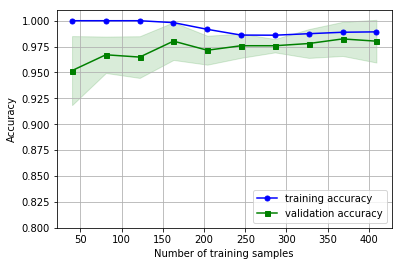

In [8]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

pipe_lr = make_pipeline(StandardScaler(), 
                        LogisticRegression(penalty='l2', 
                                           random_state=1))

train_sizes, train_scores, test_scores =\
    learning_curve(estimator=pipe_lr, 
                   X=X_train, y=y_train, 
                   train_sizes=np.linspace(0.1, 1.0, 10), 
                   cv=10, n_jobs=1)
    
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', 
         marker='o', markersize=5, 
         label='training accuracy')
plt.plot(train_sizes, test_mean, color='green', 
         marker='s', markersize=5, 
         label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, 
                 test_mean - test_std, alpha=0.15, 
                 color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.01])
plt.show()

Via the *train_sizes* parameter in the *learning_curve* function, we can control the absolute or relative number of training samples that are used to generate the learning curves. Here, we set *train_sizes=np.linspace(0.1, 1.0, 10)* to use 10 evenly spaced, relative intervals for the training set sizes. By default, the *learning_curve* function uses stratified k-fold cross-validation to calculate the cross-validation accuracy of a classifier, and we set $k=10$ via the *cv* parameter for 10-fold stratified cross-validation. Then, we simply calculated the average accuracies from the returned cross-validated training and set scores for the different sizes of the training set, which we plotted using Matplotlib's *plot* function. Furthermore, we added the standard deviation of the average accuracy to the plot using the *fill_between* function to indicate the variance of the estimate. 

As we can see in the preceding learning curve plot, our model performs quite well on both the training and validation datasets if it had seen more than 250 samples during training. We can also see that the training accuracy increases for training sets with fewer than 250 samples, and the gap between validation and training accuracy widens, an indicator of an increasing degree of overfitting. 

# Addressing over- and underfitting with validation curves

Validation curves are a useful tool for improving the performance of a model by addressing issues such as overfitting and underfitting. Validation curves are related to learning curves, but instead of plotting the training and test accuracies as functions of the sample size, we vary the number of the model parameters, for example, the inverse regularization parameter *C* in logistic regression. Let's go ahead and see how we create validation curves via scikit-learn: 

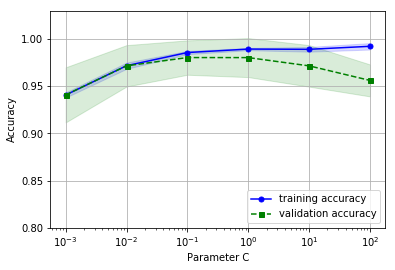

In [9]:
from sklearn.model_selection import validation_curve

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = \
    validation_curve(estimator=pipe_lr, 
                     X=X_train, y=y_train, 
                     param_name='logisticregression__C', 
                     param_range=param_range, cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, color='blue', marker='o', 
         markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean + train_std, 
                 train_mean - train_std, alpha=0.15, 
                 color='blue')
plt.plot(param_range, test_mean, color='green', 
         linestyle='--', marker='s', markersize=5, 
         label='validation accuracy')
plt.fill_between(param_range, test_mean + test_std, 
                 test_mean - test_std, alpha=0.15, 
                 color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.03])
plt.show()

Similar to the *learning_curve* function, the *validation_curve* function uses stratified k-fold cross-validation by default to estimate the performance of the classifier. Inside the *validation_curve* function, we specified the parameter that we wanted to evaluate. In this case, it is *C*, the inverse regularization parameter of the *LogisticRegression* classifier, which we wrote as *'logisticregression__C'* to access the *LogisticRegression* object inside the scikit-learn pipeline for a specified value range that we set via the *param_range* parameter. Similar to the learning curve example in the previous section, we plotted the average training and cross-validation accuracies and the corresponding standard deviation. 

Although the differences in the accuracy for varying values of *C* are subtle, we can see that the model slightly underfits the data when we increase the regularization strength (small values of *C*). However, for large values of *C*, it means lowering the strength of regularization, so the model tends to slightly overfit the data. In this case, the sweet pot appears to be between 0.01 and 0.1 of the *C* value. 

# Fine-tuning machine learning models via grid search

In machine learning, we have two types of parameters: those that are learned from the training data, for example, the weights in logistic regression, and the parameters of a learning algorithm that are optimized separately. The latter are the tuning parameters, also called **hyperparameters**, of a model, for example, the regularization parameter in logistic regression or the depth parameter of a decision tree. 

In the previous section, we used validation curves to improve the performance of a model by tuning one of its hyperparameters. In this section, we will take a look at a popular hyperparameter optimization technique called **grid search** that can further help improve the performance of a model by finding the *optimal* combination of hyperparameter values. 

## Tuning hyperparameters via grid search

The approach of grid search is quite simple; it is a brute-force exhaustive search paradigm where we specify a list of values for different hyperparameters, and the computer evaluates the model performance for each combination of those to obtain the optimal combination of values from this set:

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']}, 
              {'svc__C': param_range, 
               'svc__gamma': param_range, 
               'svc__kernel': ['rbf']}]
gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10, n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9846153846153847
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


Using the preceding code, we initialized a *GridSearchCV* object form the *sklearn.model_selection* module to train and tune a **Support Vector Machine (SVM)** pipeline. We set the *param_grid* parameter of *GridSearchCV* to a list of dictionaries to specify the parameters that we would want to tune. For the linear SVM, we only evaluated the inverse regulatization parameter *C*; for the RBF kernel SVM, we tuned both the *C* and *gamma* parameter. Note that the *gamma* parameter is specific to kernel SVMs. 

After we used the training data to perform the grid search, we obtained the score of the best-performing model via the *best_score_* attribute and looked at its parameters that can be accessed via the *best_params_* attribute. In this particular case, the RBF-kernel SVM model with *svc__C* = 100.0 yielded the best k-fold cross-validation accuracy: 98.5 percent. 

Finally, we will use the independent test dataset to estimate the performance of the best-selected model, which is available via the *best_estimator_* attribute of the *GridSearchCV* object: 

In [11]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))

Test accuracy: 0.974


Although grid search is a powerful approach for finding the optimal set of paramters, the evaluation of all possible parameter combinations is also computationally very expensive. An alternative approach to sampling different parameter combinations using scikit-learn is randomized search. Using the *RandomizedSearchCV* class in scikit-learn, we can draw random parameter combinations from sampling distributions with a specified budget. 

## Algorithm selection with nested cross-validation

Using k-fold cross-validation in combination with grid search is a useful approach for fine-tuning the performance of a machine learning model by varying its hyperparameter values, as we saw in the previous subsection. If we want to select among different machine learning algorithms, though, another recommended approach is nested cross-validation. In a nice study on the bias in error estimation, Varma and Simon concluded that the true error of the estimate is almost unbiased relative to the test set when nested cross-validation is used.

In nested cross-validation, we have an outer k-fold cross-validation loop to split the data into training and test folds, and an inner loop is used to select the model using k-fold cross-validation on the training fold. After model selection, the test fold is then used then used to evaluate the model performance. The following picture explains the concept of nested cross-validation with only five outer and two inner folds, which can be useful for large datasets where computationally performance is important; this particular type of nested cross-validation is also known as **5x2 cross-validation**: 

<img src='images/06_07.png'>

In scikit-learn, we can perform nested cross-validation as follows: 

In [12]:
gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', cv=2)
scores = cross_val_score(gs, X_train, y_train, 
                         scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), 
                                      np.std(scores)))

CV accuracy: 0.974 +/- 0.015


The returned average cross-validation accuracy gives us a good estimate of what to expect if we tune the hyperparameters of a model and use it on unseen data. For example, we can use the nested cross-validation approach to compare an SVM model to a simple decision tree classifier; for simplicity, we will only tune its depth parameter:

In [13]:
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0), 
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}], 
                  scoring='accuracy', cv=2)
scores = cross_val_score(gs, X_train, y_train, 
                         scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), 
                                      np.std(scores)))

CV accuracy: 0.934 +/- 0.016


As we can see, the nested cross-validation performance of the SVM model (97.4 percent) is notably better then the performance of the decision tree (93.4 percent), and thus, we would expect that it might be the better choice to classify new data that comes from the same population as this particular dataset. 

# Looking at different performance evaluation metrics

In the previous sections and chapters, we evaluated our models using model accuracy, which is a useful metric with which to quantify the performance of a model in general. However, there are several other performance metrics that can be used to measure a model's relevance, such as precision, recall, and F1-score. 

## Reading a confusion matrix

Before we get into the details of different scoring metrics, let's take a look at a **confusion matrix**, a matrix that lays out the performance of a learning algorithm. The confusion matrix is simply a square matrix that reports the counts of the *True positive (TP), True negative (TN), False positive (FP) and False negative (FN)* predictions of a classifier, as shown in the following figure: 

<img src='images/06_08.png'>

Although these metrics can be easily computed manually by comparing the true and predicted class labels, scikit-learn provides a convenient *confusion_matrix* function that we can use, as follows:

In [14]:
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


The array that was returned after executing the code provides us with information about the different types of error the classifier made on the test dataset. We can map this information onto the confusion matrix illustration in the previous figure using Matplotlib's *matshow* function: 

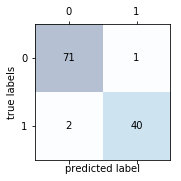

In [15]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], 
                va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true labels')
plt.show()

Assuming that class 1 (malignant) is the positive class in this example, our model correctly classified 71 of the samples that belong to class 0 (TNs) and 40 samples that belong to class 1 (TPs), respectively. However, our model also incorrectly misclassified two samples from class 1 as class 0 (FN), and it predicted that one sample is malignant although it is a benign tumor (FP). In the next section, we will learn how we can use this information to calculate various error metrics. 

## Optimizing the precision and recall of a classification model

Both the precision **error (ERR)** and **accuracy (ACC)** provide general information about how many samples are misclassified. The error can be understood as the sum of all false predictions divided by the number of total predications, and the accuracy is calculated as the sum of corrected predictions divided by the total number of predictions, respectively: 

$$ERR = \frac{FP + FN}{FP + FN + TP + TN}$$

The prediction accuracy can then be calculated directly from the error:

$$ACC = \frac{TP + TN}{FP + FN + TP + TN} = 1 - ERR$$

The **True positive rate (TPR)** and **False positive rate (FPR)** are performance metrics that are especially useful for imbalanced class problems: 

$$FPR = \frac{FP}{N} = \frac{FP}{FP+TN}$$

$$TPR = \frac{TP}{N} = \frac{TP}{FN+TN}$$

In tumor diagnosis, for example, we are more concerned about the detection of malignant tumors in order to help the patient with the appropriate treatment. However, it is also important to decrease the number of benign tumors that are incorrectly classified as malignant (FPs) to not unnecessarily concern a patient. In contrast to the FPR, the TPR provides useful information about the fraction of positive (or relevant) samples that were correctly identified out of the total pool of positives (P). 

The performance metrics **precision (PRE)** and **recall (REC)** are related to those true positive and negative rates, and in fact, REC is synonymous with TPR: 

$$PRE = \frac{TP}{TP + FP}$$

$$REC = TPR = \frac{TP}{P} = \frac{TP}{FN + TP}$$

In practice, often a combination of PRE and REC is used, the so-called **F1-score**: 

$$F1 = 2\frac{PRE * REC}{PRE + REC}$$

Those scoring metrics are all implemented in scikit-learn and can be imported from the *scikit-metrics* module as shown in the following snippet: 

In [16]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Precision: 0.976
Recall: 0.952
F1: 0.964


Furthermore, we can use a different scoring metric than accuracy in the *GridSearchCV* via the scoring parameter. 

Remember that the positive class in scikit-learn is the class that is labeled as class 1. If we want to specify a different *positive label*, we can construct our own scorer via the *make_scorer* function, which we can then directly provide as argument to the scoring parameter in *GridSearchCV* (in this example, using the *f1_score* as a metric):  

In [17]:
from sklearn.metrics import make_scorer

scorer = make_scorer(f1_score, pos_label=0)
gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring=scorer, 
                  cv=10)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9880219137963148
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


## Plotting a receiver operating characteristic

**Receiver Operating Characteristic (ROC)** graphs are useful tools to select models for classification based on their performance with respect to the FPR and TPR, which are computed by shifting the decision threshold of the classifier. The diagonal of an ROC graph can be interpreted as *random_guessing*, and classification models that fall below the diagonal are considered as worse than random guessing. A perfect classifier would fall into the top left corner of the graph with a TPR of 1 and an FPR of 0. Based on the ROC curve, we can then compute the so-called **ROC Area Under the Curve (ROC AUC)** to characterize the performance of a classification model. 

Similar to ROC curves, we can compute **precision-recall curves** for different probability thresholds of a classifier. A function for plotting those precision-recall curves is also implemented in scikit-learn (*precision_recall_curve*). 

Executing the following code example, we will plot an ROC curve of a classifier that only uses two features from the Breast Cancer Wisconsin dataset to predict whether a tumor is belign or malignant. Although we are going to use the same logistic regression pipeline that we defined previously, we are making the classification task more challenging for the classifier so that the resulting ROC curve become visually interesting. For similar reasons, we are also reducing the number of folds in the *StratifiedKFold* validation to three. The code is as follows: 

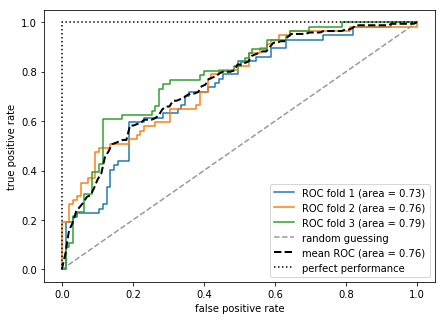

In [18]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

pile_lr = make_pipeline(StandardScaler(), 
                        PCA(n_components=2), 
                        LogisticRegression(penalty='l2', 
                                           random_state=1, 
                                           C=100.0))

X_train2 = X_train[:, [4, 14]]
cv = list(StratifiedKFold(n_splits=3, 
                          random_state=1).split(X_train, y_train))
fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train], y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train[test], 
                                     probas[:, 1], 
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, 
             label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))
    
plt.plot([0, 1], [0, 1], linestyle='--', 
         color=(0.6, 0.6, 0.6), 
         label='random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc= auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', 
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0 ,1], [0, 1, 1], linestyle=':', color='black', 
         label='perfect performance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc='lower right')
plt.show()

In the preceding code example, we used the already familiar *StratifiedKFold* class from scikit-learn and calculated the ROC performance of the *LogisticRegression* classifier in our *pipe_lr* pipeline using the *roc_curve* function from *sklearn.metrics* module separately for each iteration. Furthermore, we interpolated the average ROC curve from the three folds via the *interp* function that we imported from SciPy and calculated the area under the curve via the *auc* function. The resulting ROC curve indicates that there is a certain degree of variance between the different folds, and the average ROC AUC (0,.76) falls between a perfect score (1.0) and random guessing (0.5). 

Note if we are just interested in the ROC AUC score, we could also directly import the *roc_auc_score* function from the *sklearn.metrics* submodule. 

Reporting the performance of a classifier as the ROC AUC can yield further insights in a classifier's performance with respect to imbalanced samples. However, while the accuracy score can be interpreted as a single cut-off point on an ROC curve, A. P. Bradley showed that the ROC AUC and accuracy metrics mostly agree with each other. 

## Scoring metrics for multiclass classification

The scoring metrics that we discussed in this section are specific to binary classification systems. However, scikit-learn also implements macro and micro averaging methods to extend those scoring metrics to multiclass problems via **One-versus-All (OvA)** classification. The micro-average is calculated from the individual TPs, TNs, FPs, and FNs of the system. For example, the micro-average of the precision score in a *k*-class system can be calculated as follows: 

$$PRE_{micro} = \frac{TP_1 + \cdots + TP_k}{TP_1 + \cdots + TP_k + FP_1 + \cdots + FP_k}$$

The macro-average is simply calculated as the average score of the different systems: 

$$PRE_{macro} = \frac{PRE_1 + \cdots + PRE_k}{k}$$

Micro-averaging is useful if we want to weight each instance or prediction equally, whereas macro-averaging weights all classes equally to evaluate the overall performance of a classifier with regard to the most frequent class labels. 

If we are using binary performance metrics to evaluate multiclass classification models in scikit-learn, a normalized or weighted variant of the macro-average is used by default. The weighted macro-average is calculated by weighting the score of each class label by the number of true instances when calculating the average. The weighted macro-average is useful if we are dealing with class imbalances, that is, different numbers of instances for each label. 

While the weighted macro-average is the default for multiclass problems in scikit-learn, we can specify the averaging method via the *average* parameter inside the different scoring functions that we import from the *sklearn.metrics* module, for example, the *precision_score* or *make_scorer* functions:

In [19]:
pre_scorer = make_scorer(score_func=precision_score, 
                         pos_label=1, 
                         greater_is_better=True, 
                         average='micro')

# Dealing with class imbalance

We have mentioned class imbalances several times throughout this chapter, and yet we have not actually discussed how to deal with such scenarios appropriately if they occur. Class imbalance is a quite common problem when working with real-world data - samples from one class or multiple class are over-represented in a dataset. Intuitively, we can think of several domains where this may occur, such as spam filtering, fraud detection, or screening for diseases.

Imagine the breast cancer dataset that we have been working with in this chapter consisted of 90 percent healthy patients. In this case, we could achieve 90 percent accuracy on the test dataset by just predicting the majority class (benign tumor) for all samples, without the help of a supervised machine learning algorithm. Thus, training a model on such a dataset that achieves approximately 90 percent test accuracy would mean our model has not learning anything useful from the features provided in this dataset. 

In this section, we will briefly go over some of the techniques that could help with imbalanced datasets. But before we discuss different methods to approach this problem, let's create an imbalanced dataset from our breast cancer dataset, which originally consisted of 357 benign tumors (class 0) and 212 malignant tumors (class 1): 

In [21]:
X_imb = np.vstack((X[y==0], X[y==1][:40]))
y_imb = np.hstack((y[y==0], y[y==1][:40]))

In the previous code snippet, we took all 357 benign tumor samples and stacked them with the first 40 malignant samples to create a stark class imbalance. If we were to compute the accuracy of a model that always predicts the majority class (benign, class 0), we would achieve a prediction accuracy of approximately 90 percent:

In [22]:
y_pred = np.zeros(y_imb.shape[0])
np.mean(y_pred == y_imb) * 100

89.92443324937027

Thus, when we fit classifiers on such datasets, it would make sense to focus on the other metrics than accuracy when comparing different models, such as precision, recall, the ROC curve - whatever we care most about in our application. For instance, our priority might be to identify the majority of patients with malignant cancer patients to recommend an additional screening, then recall should be our metric of choice. In spam filtering, where we do not want to label emails as spam if the system is not very certain, precision might be a more appropriate metric. 

Aside from evaluating machine learning models, class imbalance influences a learning algorithm during model fitting itself. Since machine learning algorithms typically optimize a reward or cost function that is computed as a sum over the training examples that it sees during fitting,  the decision rule is likely going to be biased towards the majority class. In other words, the algorithm implicitly learns a model that optimizes the predictions based on the most abundant class in the dataset, in order to maximize the cost or maximize the reward during training. 

One way to deal with imbalanced class proportions during model fitting is to assign a larger penalty to wrong predictions on the minority class. Via scikit-learn, adjusting a penalty is as convenient as setting the *class_weight* parameter to *class_weight='balanced'*, which is implemented for most classifiers. 

Other popular strategies for dealing with class imbalance include upsampling the minority class, downsampling the majority class, and the generation of synthetic training samples. Unfortunately, there is no universally best solution, no technique that works best across different problem domains. Thus, in practice, it is recommended to try out different strategies on a given problem, evaluate the results, and choose the technique that seems most appropriate. 

The scikit-learn library implements a simple *resample* function that can help with the upsampling of the minority class by drawing new samples from the dataset with replacement. The following code will take the minority class from our imbalanced breast cancer dataset (here, class 1) and repeatedly draw new samples from it until it contains the same number of samples as class label 0:

In [23]:
from sklearn.utils import resample

print('Number of class 1 samples before:', 
      X_imb[y_imb==1].shape[0])
X_upsampled, y_upsampled = resample(X_imb[y_imb==1], 
                                    y_imb[y_imb==1], 
                                    replace=True, 
                                    n_samples=X_imb[y_imb==0].shape[0], 
                                    random_state=123)
print('Number of class 1 samples after:', X_upsampled.shape[0])

Number of class 1 samples before: 40
Number of class 1 samples after: 357


After resampling, we can then stack the original class 0 samples with the upsampled class 1 subset to obtain a balanced dataset as follows: 

In [24]:
X_bal = np.vstack((X[y==0], X_upsampled))
y_bal = np.hstack((y[y==0], y_upsampled))

Consequently, a majority vote prediction rule would only achieve 50 percent accuracy: 

In [25]:
y_pred = np.zeros(y_bal.shape[0])
np.mean(y_pred == y_bal) * 100

50.0

Similarly, we could downsample the majority class by removing training samples from the dataset. To perform downsampling using the *resample* function, we could simply swap the class 1 label with class 0 in the previous code example and vice versa. 

Another technique for dealing with class imbalance is the generation of synthetic training samples, which is beyond the scope of this book. The probably most widely used algorithm for synthetic training sample generation is **Synthetic Minority Over-sampling Technique (SMOTE)**. It is also highly recommended to check out *imbalanced-learn*, a Python library that is entirely focused on imbalanced datasets, including an implementation of SMOTE. 

# Summary

At the beginning of this chapter, we discussed how to chain different transformation techniques and classifiers in convenient model pipelines that helped us train and evaluate machine learning models more efficiently. We then used those pipelines to perform k-fold cross-validation, one of the essential techniques for model selection and evaluation. Using k-fold cross-validation, we plotted learning and validation curves to diagnose the common problems of learning algorithms, such as overfitting and underfitting. Using grid search, we further fine-tuned our model. We concluded this chapter by looking at a confusion matrix and various performance metrics that can be useful to further optimize a model's performance for a specific problem task. Now, we should be well-equipped with the essential techniques to build supervised machine learning models for classification successfully. 

In the next chapter, we will look at ensemble methods: methods that allow us to combine multiple models and classification algorithms to boost the predictive performance of a machine learning system even further. 